In [1]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt

from ta.utils import dropna
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.trend import MACD
from ta.momentum import RSIIndicator

In [2]:
# TODO
# Create a automated train testor and test different variations

# Hypothesis

From testing we found that simply using indicators was not enough to find tops and bottom and even mean reversion often did not work due to irrational investors and market risk

Hence, instead of longing at a potential lows, we wanted to test the returns of longing only in the middle of a new uptrend. 

Our strategy is as such:

Long when
1. Adj Close is between  50 day SMA value & (50 day SMA value + 3x ATR) 
        i.  A stronger signal is when Diff between (SMA & Adj Close) is large
2.  AND (MACD line(Fast)– Signal(Slow)) is also positive and large
        i. A stronger signal is when Diff between (MACD line(Fast)– Signal(Slow)) is large

Short when
1. Adj Close is between (50 day SMA value - 0.5x ATR) &  50 day SMA value 
        i.  A stronger signal is when Diff between (SMA & Adj Close) is large
2.  AND (MACD line(Fast)– Signal(Slow))  is also negative and large 
        i. A stronger signal is when Diff between (MACD line(Fast)– Signal(Slow)) is large


In [3]:
def get_signal_per_day(adj_close_val, sma_val,macd_fast_val, macd_slow_val,close_n_sma_distance_short_multiple, close_n_sma_distance_long_multiple,atr_val):
    """
    Function to visualise how signals are calculated for each day
    """
    
    signal_short = -1.0 if (adj_close_val>(sma_val-close_n_sma_distance_short_multiple*atr_val)) & (adj_close_val<sma_val) else 0
    signal_long_n_short = 1.0 if (adj_close_val<(sma_val+close_n_sma_distance_long_multiple*atr_val)) & (adj_close_val>sma_val) else signal_short
    singal_macd = 1.0 if (macd_fast_val>macd_slow_val) else -1.0
    final_signal = (signal_long_n_short+singal_macd)/2.0
    final_signal_clean = final_signal if (final_signal in [1.0,-1,0]) else 0
    signal_strength = ((abs(adj_close_val- sma_val)/adj_close_val + abs(macd_fast_val-macd_slow_val))) * final_signal_clean
    
    return final_signal_clean,signal_strength

In [4]:
get_signal_per_day(adj_close_val= 275.79,sma_val= 267,
                   macd_fast_val= 0.029,macd_slow_val= -1.59,
                   close_n_sma_distance_short_multiple= 0.5,
                   close_n_sma_distance_long_multiple= 3,
                   atr_val = 8.22)

(1.0, 1.6508720765800067)

### Importing Data

In [5]:
#NSElist . Dont run
india_stock_list  = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS" , "BAJAJ-AUTO.NS", "GRASIM.NS","ONGC.NS", "TITAN.NS" , "SHREECEM.NS" ,\
        "NESTLEIND.NS", "GAIL.NS", "CIPLA.NS", "BHARTIARTL.NS" ,"NTPC.NS", "TATASTEEL.NS", "COALINDIA.NS", "BAJFINANCE.NS", "ICICIBANK.NS",\
       "BAJAJFINSV.NS", "WIPRO.NS", "HINDALCO.NS" , "HDFCLIFE.NS", "MARUTI.NS", "RELIANCE.NS", "TCS.NS", "LT.NS", "INDUSINDBK.NS", "ITC.NS" , "TECHM.NS"]

In [6]:
#SGX Stock list. Dont run
sg_stock_list  = ["C52.SI", "T39.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI",\
        "D01.SI", "O39.SI", "S63.SI", "A17U.SI" , "BN4.SI","BS6.SI", "M44U.SI", "C31.SI", "H78.SI", \
        "Y92.SI", "C38U.SI", "U14.SI", "N2IU.SI" , "F34.SI" , "C09.SI" , "J36.SI", "S58.SI" , "C6L.SI", "J37.SI", "U96.SI" ,"1810.HK"]

In [16]:
class SMACD():  

    def __init__(self, stock_list, start, end, primary_trend_window, buy_on, verbose,lookback = 252,metrics_calc_start_date = "2015-01-01"):

        self.stock_list = stock_list
        self.primary_trend_window = primary_trend_window
        self.buy_on= buy_on
        self.start = start
        self.end = end
        self.verbose = verbose
        self.lookback = lookback
        self.metrics_calc_start_date = metrics_calc_start_date
        self.bt_data = pd.DataFrame()
        self.get_signal_for_mutiple_stocks()


    def get_signals_single_stock(self,stock_symbol):
        """
        Vectorised Function to get the signals for each day 
        """
        
        stock_data = pdr.get_data_yahoo(stock_symbol, start, end)
        SMA = SMAIndicator(close = stock_data['Adj Close'], window = primary_trend_window)
        ATR = AverageTrueRange(high = stock_data['High'],
                           low = stock_data['Low'],
                           close = stock_data['Adj Close'])
        RSI = RSIIndicator(close =  stock_data['Adj Close'])

        MACD_ = MACD(close = stock_data['Adj Close'])  

        stock_data['SMA'] = SMA.sma_indicator()
        stock_data['ATR'] = ATR.average_true_range()
        stock_data['MACD Fast'] = MACD_.macd()
        stock_data['MACD Slow'] = MACD_.macd_signal()
        stock_data['RSI'] = RSI.rsi()

        stock_data['Stop Loss'] = stock_data[buy_on] - long_sl_ATR_multiple*stock_data['ATR'] # 2
        stock_data['Take Profit'] = stock_data[buy_on] +risk_reward_long*(stock_data[buy_on] - stock_data['Stop Loss']) # 1

        stock_data['Stop Loss Short'] = stock_data[buy_on] + short_sl_ATR_multiple*stock_data['ATR'] # 1
        stock_data['Take Profit Short'] = stock_data[buy_on] -risk_reward_short*(stock_data['Stop Loss Short'] - stock_data[buy_on]) # 0.5

        bt_data = stock_data.copy()
        bt_data.dropna(inplace = True)

        # # Signal Logic
        bt_data['signal_1'] = np.where( 
                            (bt_data['Adj Close'] > (bt_data['SMA'] - close_n_sma_distance_short_multiple*bt_data['ATR']) ) & (bt_data['Adj Close'] < bt_data['SMA']),
                            -1.0,   0) # When it is between the close and abit below it, we short, 0,5

        bt_data['signal_1'] = np.where( 
                            (bt_data['Adj Close'] < (bt_data['SMA'] + close_n_sma_distance_long_multiple*bt_data['ATR']) ) & (bt_data['Adj Close'] > bt_data['SMA']) ,
                            1.0,  bt_data['signal_1']) # When it is between the close and abit above it, we long, 2

        bt_data['signal_2'] = np.where(bt_data['MACD Fast'] >  bt_data['MACD Slow'],1.0,-1.0)
        bt_data['Signal'] = ( bt_data['signal_1']+ bt_data['signal_2'] )/2.0
        bt_data['Signal Clean'] = bt_data['Signal'].map(lambda x : 0 if x not in [-1.0,1.0] else x)
        bt_data['Strength of Signal'] = ((abs(bt_data['Adj Close'] - bt_data['SMA'])/bt_data['Adj Close'] + abs(bt_data['MACD Fast'] -  bt_data['MACD Slow']))) * bt_data['Signal Clean']
        bt_data['Stock_Returns'] = np.log(bt_data[buy_on]/bt_data[buy_on].shift(1)) 
        bt_data['Stock_Returns'] = bt_data['Stock_Returns'].shift(-1) # Changed to tmr/today instead of today/yesterday
        return bt_data
    
    def get_signal_for_mutiple_stocks(self):
        """
        Function that combines data and signals for multiple stocks 
        """

        stock_list_abbr_list = []
        stock_list = self.stock_list
        # Intialise df with first stock in list 
        signals_df = self.get_signals_single_stock(stock_list[0]).add_suffix('_'+stock_list[0]) 
        stock_list_abbr_list.append("Strength of Signal_" +stock_list[0])
        for stock in stock_list[1:]:
            stock_df = self.get_signals_single_stock(stock)
            signals_df= signals_df.merge(stock_df.add_suffix('_'+stock), how='right', left_index=True, right_index=True )
            stock_list_abbr_list.append("Strength of Signal_" +stock)

        signals_df['Chosen'] = signals_df[stock_list_abbr_list].abs().idxmax(axis=1)
        signals_df['Chosen'] = np.where (signals_df[stock_list_abbr_list].abs().max(axis = 1) == 0.0, 0, signals_df['Chosen'])
        temp_data = signals_df[stock_list_abbr_list].copy()

        # If there are many signals in one day, replace them with the stock with the strongest signal
        for i in range(len(temp_data)):
            if (temp_data[i:i+1].max(axis = 1)[0] != 0.0):
                stock_chosen = temp_data[i:i+1].abs().idxmax(axis=1)[0].split("_")[-1]
                signals_df.loc[signals_df.index[i],stock_list_abbr_list] = [0.0] * len(stock_list_abbr_list)
                signals_df.loc[signals_df.index[i],"Strength of Signal_"+stock_chosen] = signals_df.loc[signals_df.index[i],"Signal Clean_"+stock_chosen]
        self.bt_data = signals_df.copy()

    def get_positions(self):
        """
        Function to set the entry points for the day.
        Once, entered position will stay in that stock untill it hits TP or SL
        After closing the position, based on the next signal a new position is opened.
        """
        latest_action,chosen_stock_for_entry = 0,""
        curr_stop, curr_TP,buy_price,short_price = 0,0,0,0
        bt_data = self.bt_data
        bt_data[ "Open_Entry"] = 0.0
        bt_data[ "Close_Entry"] = ""
        bt_data[ "Stock_Returns_"] = 0.0
        bt_data[ buy_on+"_"] = 0.0
        buy_rsi = []
        sell_rsi = []
        
        # Loop through each day
        for i in range(len(bt_data)):
            curr_date = bt_data.index[i]

            # If we have no prev position and a new signal is asking to take a position
            if (bt_data['Chosen'].iloc[i] != 0.0) & (latest_action == 0):

                chosen_stock_for_entry = bt_data['Chosen'].iloc[i].split('_')[-1]

                # Enter Long on chosen stock
                if (bt_data["Signal Clean_"+chosen_stock_for_entry].iloc[i]  == 1.0):
                    curr_stop, curr_TP = bt_data.iloc[i]["Stop Loss_"+chosen_stock_for_entry],bt_data.iloc[i]["Take Profit_"+chosen_stock_for_entry]
                    latest_action = 1.0
                    bt_data.loc[curr_date, "Open_Entry"] = "Open Long"
                    buy_price = bt_data.iloc[i+1][buy_on+"_" + chosen_stock_for_entry]
                    buy_rsi.append(bt_data.iloc[i+1]["RSI_" + chosen_stock_for_entry])
                    if verbose: print(f"Signal to Open Long on {chosen_stock_for_entry} on {curr_date} at {buy_price}")

                # Enter Short on chosen stock
                elif (bt_data["Signal Clean_"+chosen_stock_for_entry].iloc[i]  == -1.0):
                    curr_stop, curr_TP = bt_data.iloc[i]["Stop Loss Short_"+chosen_stock_for_entry],bt_data.iloc[i]["Take Profit Short_"+chosen_stock_for_entry]
                    latest_action = -1.0  
                    bt_data.loc[curr_date, "Open_Entry"] = "Open Short"
                    short_price = bt_data.iloc[i+1][buy_on+"_" + chosen_stock_for_entry]
                    sell_rsi.append(bt_data.iloc[i+1]["RSI_" + chosen_stock_for_entry])
                    if verbose: print(f"Signal to Open Short on {chosen_stock_for_entry} on {curr_date} at {short_price}")

            # if we are already in a long    
            elif (latest_action == 1.0):
                # Close Long if it hits TP
                if (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  >= curr_TP ) | (bt_data.iloc[i]["RSI_" + chosen_stock_for_entry]>long_rsi_limit): 
                    bt_data.loc[curr_date, "Close_Entry"] = "Close Long at TP"
                    if verbose: print(f"Signal to Take Profit on Long with {chosen_stock_for_entry} on {curr_date} at {curr_TP} with a profit of {(curr_TP-buy_price)/buy_price}")
                    latest_action,curr_stop, curr_TP = 0,0, 0


                # Close Long if it hits SL
                elif (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  <= curr_stop ): 
                    bt_data.loc[curr_date, "Close_Entry"] = "Close Long at SL"
                    if verbose:print(f"Signal to Stop Loss on Long on {chosen_stock_for_entry} on {curr_date} at {curr_stop} with a loss of {(curr_stop-buy_price)/buy_price}")
                    latest_action,curr_stop, curr_TP = 0,0, 0

            # if we are already in a short
            elif (latest_action == -1.0):

                # Close Short if it hits SL
                if (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  >= curr_stop) : 
                    bt_data.loc[curr_date, "Close_Entry"] = "Close Short at SL"
                    if verbose: print(f"Signal to Stop Loss on Short with {chosen_stock_for_entry} on {curr_date} at {curr_stop} with a loss of {-(curr_stop-short_price)/short_price}")
                    latest_action,curr_stop, curr_TP = 0,0, 0


                # Close Short if it hits TP
                elif (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  <= curr_TP) | (bt_data.iloc[i]["RSI_" + chosen_stock_for_entry]<short_rsi_limit): 
                    bt_data.loc[curr_date, "Close_Entry"] = "Close Short at TP"
                    if verbose: print(f"Signal to Take Profit on Short on {chosen_stock_for_entry} on {curr_date} at {curr_TP} with a profit of {-(curr_TP-short_price)/short_price}")
                    latest_action,curr_stop, curr_TP = 0,0, 0

            bt_data.loc[curr_date, "Position"] = latest_action
            bt_data.loc[curr_date, "Invested Stock Returns"] = bt_data.loc[curr_date, "Stock_Returns_" + chosen_stock_for_entry]
            bt_data.loc[curr_date, "Invested Stock Price"] = bt_data.loc[curr_date, buy_on+"_" + chosen_stock_for_entry]
            bt_data.loc[curr_date, "Invested in"] = chosen_stock_for_entry

    def riding_the_trend_with_macd(self):
        benchmark_data = pdr.get_data_yahoo(benchmark_stock_symbol, self.start, self.end)
        
        # Getting position for each day based on the strongest signal
        self.get_positions()
        bt_data = self.bt_data

        # Printing the distribution of positions
        print("\nDistribution of Positions,\n",bt_data.Position.value_counts())
        assert bt_data.Position.isin([-1.0,0,1.0]).all(), "Position values are out of range:\n"  + bt_data.Position.value_counts().to_string()

        # Printing the number of entires and exits 
        number_trades = bt_data[bt_data.Open_Entry != 0.0].Open_Entry.count() + bt_data[bt_data.Close_Entry != ""].Close_Entry.count()
        no_trades = bt_data[bt_data.Position == 0.0].Position.count() 
        print("\nDistribution of exits in percentages\n",bt_data[bt_data.Close_Entry != ""].Close_Entry.value_counts(normalize=True))
        print(f'\nNumber of Entries and Exits are {number_trades} and No trade are {no_trades} \n' )

        # Assuming, we get a signal on open and we are able to buy on the same day open as well
        bt_data['Benchmark_Returns'] = np.log(benchmark_data[buy_on]/benchmark_data[buy_on].shift(1))
        bt_data['Benchmark_Returns'] = bt_data['Benchmark_Returns'].shift(-1)
        bt_data['Strategy_Returns'] = bt_data['Position'].shift(1) * bt_data['Invested Stock Returns'] # since you enter next day
        bt_data["Invested in"] = bt_data.apply(lambda row: row["Invested in"] if (row["Strategy_Returns"]!=0.0) else "", axis = 1)

        # Plotting entry points and returns 
        for stock in self.stock_list:
            figure, axis = plt.subplots(2,figsize=(12, 6))
            self.entry_price_plot(bt_data.iloc[-lookback:], axis[0],stock )
            self.returns_plot_normal(axis[1],stock)

        # Metrics
        returns_df = pd.DataFrame()
        stock_list_abbr_list = []
        for stock in self.stock_list:
            stock_list_abbr_list.append("Stock_Returns_" +stock)
        stock_list_abbr_list.extend(["Benchmark_Returns","Strategy_Returns"])

        returns_df["Normal"] = bt_data[metrics_calc_start_date:][stock_list_abbr_list].sum().apply(np.exp)
        returns_df["Log"] = bt_data[metrics_calc_start_date:][stock_list_abbr_list].sum()

        metrics_df = pd.DataFrame()
        metrics_df["Annual Mean Returns"] = np.exp(bt_data[metrics_calc_start_date:][stock_list_abbr_list].mean() * 252) -1

        # Annual Standard deviation
        metrics_df["Annual Regular std"] = (np.exp(bt_data[metrics_calc_start_date:][stock_list_abbr_list])-1).std() * (252 **0.5)  # Note that these are the log returns

        # Annual Standard deviation of Neg Returns
        neg_ret_std = []
        tracking_err = []
        information_ratio = []
        for stock in stock_list_abbr_list:
            neg_ret_std.append((np.exp(bt_data[bt_data[stock] <0][metrics_calc_start_date:][stock])-1).std() * (252 **0.5) )
            if stock != "Benchmark_Returns":
                rf_rm_diff = bt_data[metrics_calc_start_date:][stock] - bt_data[metrics_calc_start_date:]["Benchmark_Returns"]
                avg_of_diff_daily = rf_rm_diff.mean()
                sd_of_diff_daily = rf_rm_diff.std()
                IRR_daily = avg_of_diff_daily/sd_of_diff_daily
                tracking_err.append(sd_of_diff_daily*(252**0.5))
                information_ratio.append(IRR_daily *(252**0.5) )
            else:
                tracking_err.append(np.nan)
                information_ratio.append(np.nan )
        metrics_df["Annual Negative Regular std"] = neg_ret_std

        # Sharpe Ratio
        metrics_df["Annual Sharpe Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Annual Regular std'] 

        # Max Drawdown
        metrics_df["Max Drawdown"] =list(map(lambda x: self.drawdown( 0, x, False),stock_list_abbr_list))

        # Calamar Ratio
        metrics_df["Annual Calamar Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Max Drawdown'] 

        # Shortino Ratio
        metrics_df["Annual Shortino Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Annual Negative Regular std'] 

        # Tracking Error
        metrics_df["Annual Tracking Error"] = tracking_err

        # Information Ratio
        metrics_df["Annual Information Ratio"] =information_ratio

        return bt_data, returns_df,metrics_df

    def entry_price_plot(self,bt_data,plt,stock_symbol):
        """
        Function to plot the entry points and exits for each stock
        """
        bt_data = self.bt_data
        plt.grid(True, alpha = .3)
        stock_price_df = bt_data[buy_on+"_" + stock_symbol]

        # Plotting the Closing prices and SMA for the chosen stock
        plt.plot(stock_price_df, label = f'Daily {buy_on} of {stock_symbol}')
        plt.plot(bt_data['SMA'+"_" + stock_symbol], label = 'SMA')

        # Entry Points
        open_long = (bt_data.Open_Entry == "Open Long") & (bt_data.Chosen == "Strength of Signal_"+stock_symbol)
        open_short = (bt_data.Open_Entry == "Open Short") & (bt_data.Chosen == "Strength of Signal_"+stock_symbol)

        # Exit points
        close_short_tp = (bt_data.Close_Entry == "Close Short at TP") & (bt_data["Invested in"] == stock_symbol)
        close_long_tp = (bt_data.Close_Entry == "Close Long at TP") & (bt_data["Invested in"] == stock_symbol)
        close_short_sl = (bt_data.Close_Entry == "Close Short at SL") & (bt_data["Invested in"] == stock_symbol)
        close_long_sl = (bt_data.Close_Entry == "Close Long at SL") & (bt_data["Invested in"] == stock_symbol)

        plt.plot(bt_data.loc[open_long].index, stock_price_df[open_long], '^',
                 color = 'g', markersize = 12,alpha=0.6, label="Open Long")

        plt.plot(bt_data.loc[open_short].index, stock_price_df[open_short], 'v',
                 color = 'r', markersize = 12,alpha=0.6, label="Open Short")

        plt.plot(bt_data.loc[close_long_tp].index, stock_price_df[close_long_tp], '*',
                 color = 'g', markersize = 12,alpha=0.8, label="TP Long")

        plt.plot(bt_data.loc[close_short_tp].index, stock_price_df[close_short_tp], '*',
                 color = 'r', markersize = 12,alpha=0.8, label="TP Short")

        plt.plot(bt_data.loc[close_long_sl].index, stock_price_df[close_long_sl], 'x',
                 color = 'g', markersize = 12,alpha=0.8, label="SL Long", mew=4)

        plt.plot(bt_data.loc[close_short_sl].index, stock_price_df[close_short_sl], 'x',
                 color = 'r', markersize = 12,alpha=0.8, label="SL Short", mew=4)

        plt.legend(loc=(1.04, 0));


    def returns_plot_log(self,plt,stock_symbol):
        """
        Function to plot the log returns of stock and strategy 
        """
        bt_data = self.bt_data
        plt.plot(bt_data['Stock_Returns'+"_" + stock_symbol].cumsum(), label=f'Buy/Hold (Log Returns) of {stock_symbol}')
        plt.plot(bt_data['Strategy_Returns'].cumsum(), label=f'Strategy (Log Returns)')
        plt.legend(loc=(1.04, 0))
        plt.grid(True, alpha=.3)
        
    def returns_plot_normal(self,plt,stock_symbol):
        """
        Function to plot the normal returns of stock and strategy 
        """
        bt_data = self.bt_data
        plt.plot(bt_data['Stock_Returns'+"_" + stock_symbol].cumsum().apply(np.exp), label=f'Buy/Hold (Normal Returns) of {stock_symbol}')
        plt.plot(bt_data['Strategy_Returns'].cumsum().apply(np.exp), label=f'Strategy (Normal Returns)')
        plt.legend(loc=(1.04, 0))
        plt.grid(True, alpha=.3)


    def drawdown(self,plt, col,plt_bool= True):
        """
        Function to plot the drawdown of column of returns 
        """
        bt_data = self.bt_data
        bt_data["Gross_Cum_Returns"] = bt_data[col].cumsum().apply(np.exp) 
        bt_data["Cum_Max"] = bt_data["Gross_Cum_Returns"].cummax()

        if plt_bool:
            plt.plot(bt_data["Gross_Cum_Returns"],label=f'Gross Cum Returns of {col}')
            plt.plot(bt_data["Cum_Max"],label=f'Cum Max of {col}')
            plt.legend(loc=(1.04, 0))

        drawdown = bt_data["Cum_Max"] - bt_data["Gross_Cum_Returns"] # it gives the difference between orange and blue

        bt_data["drawdown"] = drawdown

        # The maximum difference is refered as "Drawdown"
        if plt_bool: print(f"Max Drawdown for {col} is {bt_data.drawdown.max()}")
        ## Try to keep to less than 15%

        zero_periods = drawdown[drawdown == 0]

        # Taking the difference from the previous period
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]

        if plt_bool: print(f'Max days for drawdown for {col} is {delta_values.max()}')

        return bt_data.drawdown.max()

In [12]:
start = "2015-01-01"
metrics_calc_start_date = "2016-01-01"
end = "2019-12-31"

primary_trend_window = 50 # 50 
lookback = 60052
buy_on = "Open"
verbose = False

# Long Parameters
long_sl_ATR_multiple = 1.5 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 2.5 # Used to determine how close to SMA can be bought
long_rsi_limit = 80

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 0.7   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5  # Used to determine how close to SMA can be bought
short_rsi_limit = 20


MAANG_list = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
benchmark_stock_symbol = "^GSPC"

In [18]:
smacd = SMACD(MAANG_list,start, end, primary_trend_window, buy_on, verbose, lookback, metrics_calc_start_date)


Distribution of Positions,
  1.0    875
-1.0    185
 0.0    150
Name: Position, dtype: int64

Distribution of exits in percentages
 Close Long at TP     0.461538
Close Short at TP    0.200000
Close Long at SL     0.200000
Close Short at SL    0.138462
Name: Close_Entry, dtype: float64

Number of Entries and Exits are 131 and No trade are 150 

                      Normal       Log
Stock_Returns_META  2.000981  0.693638
Stock_Returns_AMZN  2.806686  1.032004
Stock_Returns_AAPL  2.825553  1.038704
Stock_Returns_NFLX  2.954128  1.083204
Stock_Returns_GOOG  1.790188  0.582321
Benchmark_Returns   1.577461  0.455816
Strategy_Returns    3.774022  1.328141


,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio
Stock_Returns_META,0.189969,0.304712,0.237269,0.623436,1.178372,0.161213,0.800647,0.269508,0.221265
Stock_Returns_AMZN,0.295337,0.288129,0.226863,1.025018,1.862914,0.158535,1.301834,0.233062,0.619909
Stock_Returns_AAPL,0.297515,0.239324,0.180759,1.243147,0.697749,0.426393,1.645924,0.193769,0.754285
Stock_Returns_NFLX,0.312074,0.409597,0.295030,0.761906,2.933319,0.106389,1.057772,0.363015,0.433357
Stock_Returns_GOOG,0.157213,0.229039,0.175896,0.686404,0.538240,0.292088,0.893788,0.175128,0.181127
Benchmark_Returns,0.121082,0.119442,0.099332,1.013730,0.277851,0.435780,1.218961,NaN,NaN
Strategy_Returns,0.395184,0.264831,0.205794,1.492213,0.593573,0.665772,1.920293,0.245311,0.891653


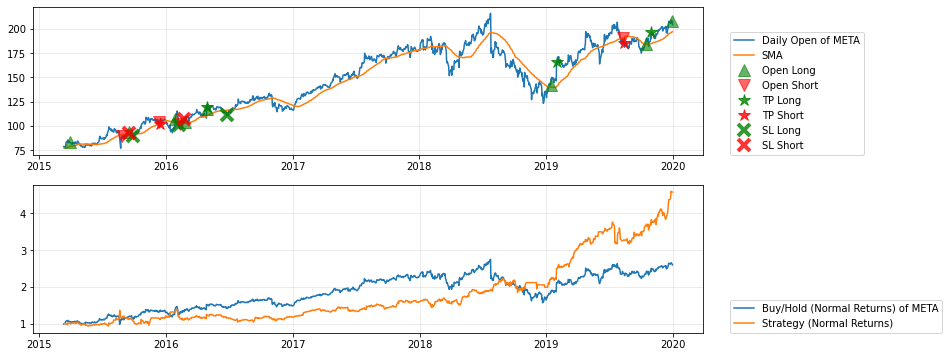

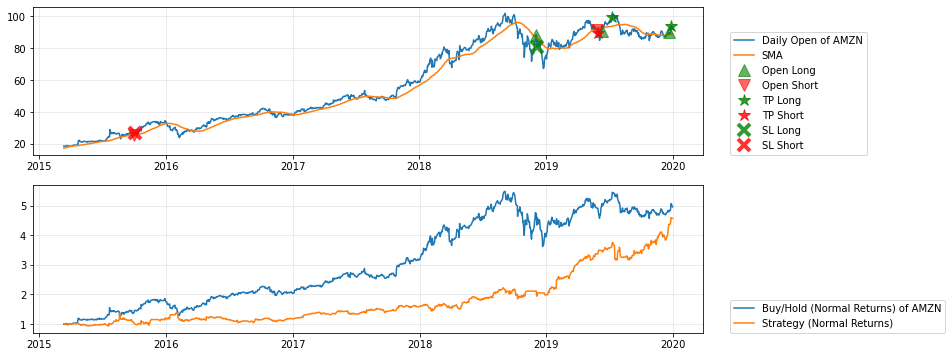

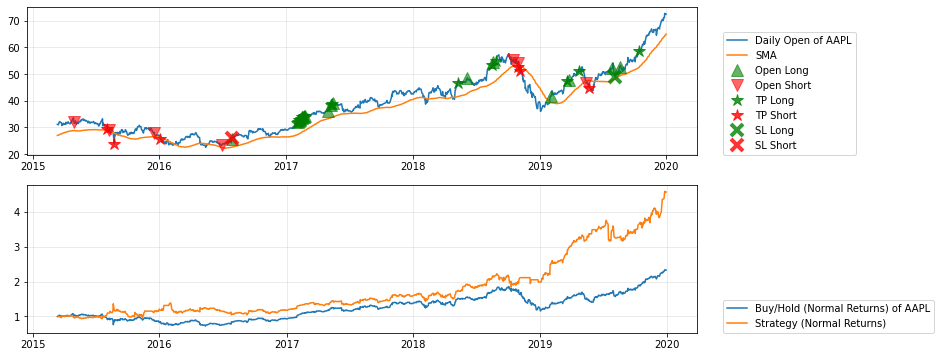

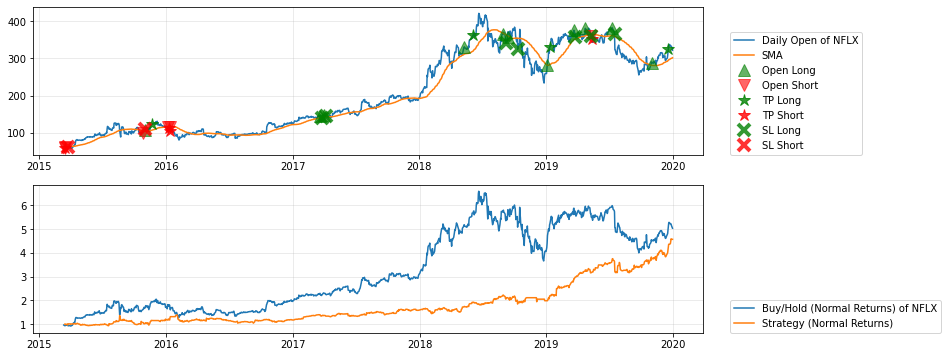

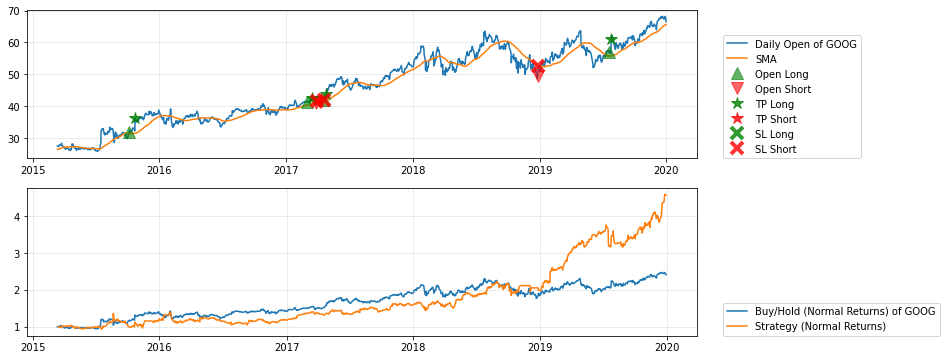

In [19]:
bt_data, returns_df,metrics_df= smacd.riding_the_trend_with_macd()
print(returns_df)
metrics_df

Use any of these below to copy the data back into excel

In [20]:
# signals_df,temp_data = get_signal_for_mutiple_stocks(MAANG_list,start, end,primary_trend_window ,buy_on)

In [21]:
# temp_data.to_clipboard()

In [22]:
# bt_data[(bt_data["Invested Stock Returns"]!= 0.0) |(bt_data["Position"]!= 0.0)][["Chosen","Open_Entry","Close_Entry","Position","Invested Stock Price","Invested Stock Returns","Invested in","Strategy_Returns"]].to_clipboard()

In [23]:
# bt_data[(bt_data["Invested Stock Returns"]!= 0.0) |(bt_data["Position"]!= 0.0)].to_clipboard()

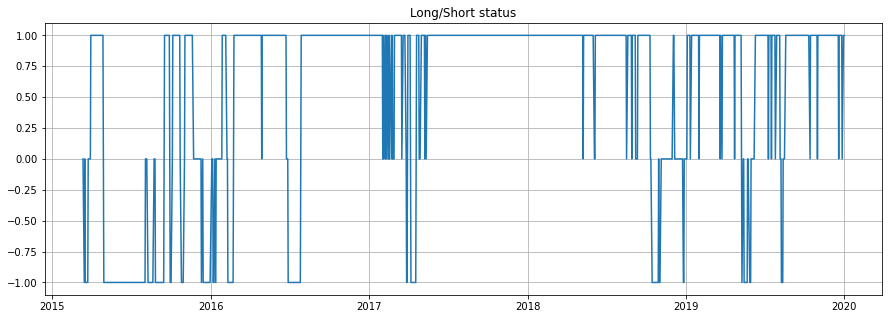

In [24]:
# Lets look from the position view Long or Short
plt.figure(figsize=(15, 5))
plt.plot(bt_data["Position"])
plt.title("Long/Short status")
plt.grid()
plt.show()

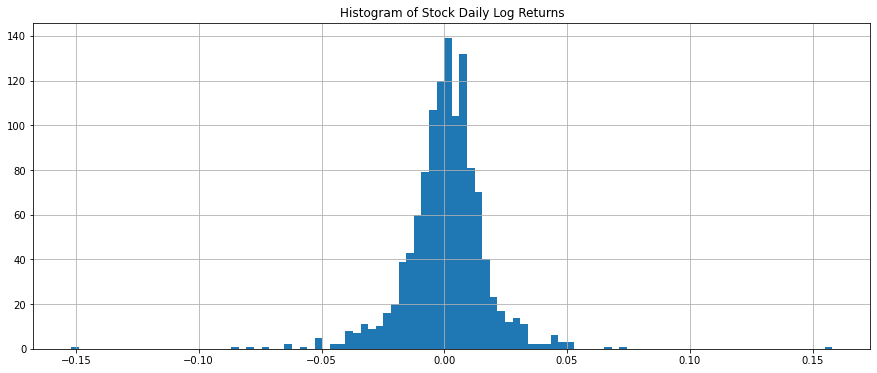

In [25]:
# The histogram of returns
plt.figure(figsize=(15, 6))
plt.hist(bt_data["Stock_Returns_AAPL"], bins = 100) 
plt.title("Histogram of Stock Daily Log Returns")
plt.grid()
plt.show()

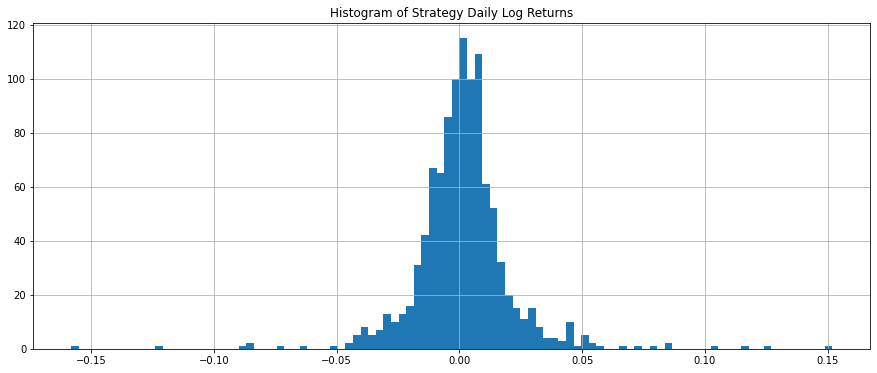

In [26]:
# The histogram of returns
# Going for less wins but big wins, Positive Skew 
# Due to close stop loss which exits out trade early but large take profits allow us to get big wins
plt.figure(figsize=(15, 6))
plt.hist(bt_data[bt_data["Strategy_Returns"]!= 0.0]["Strategy_Returns"], bins = 100) 
plt.title("Histogram of Strategy Daily Log Returns")
plt.grid()
plt.show()

KeyError: <AxesSubplot:>

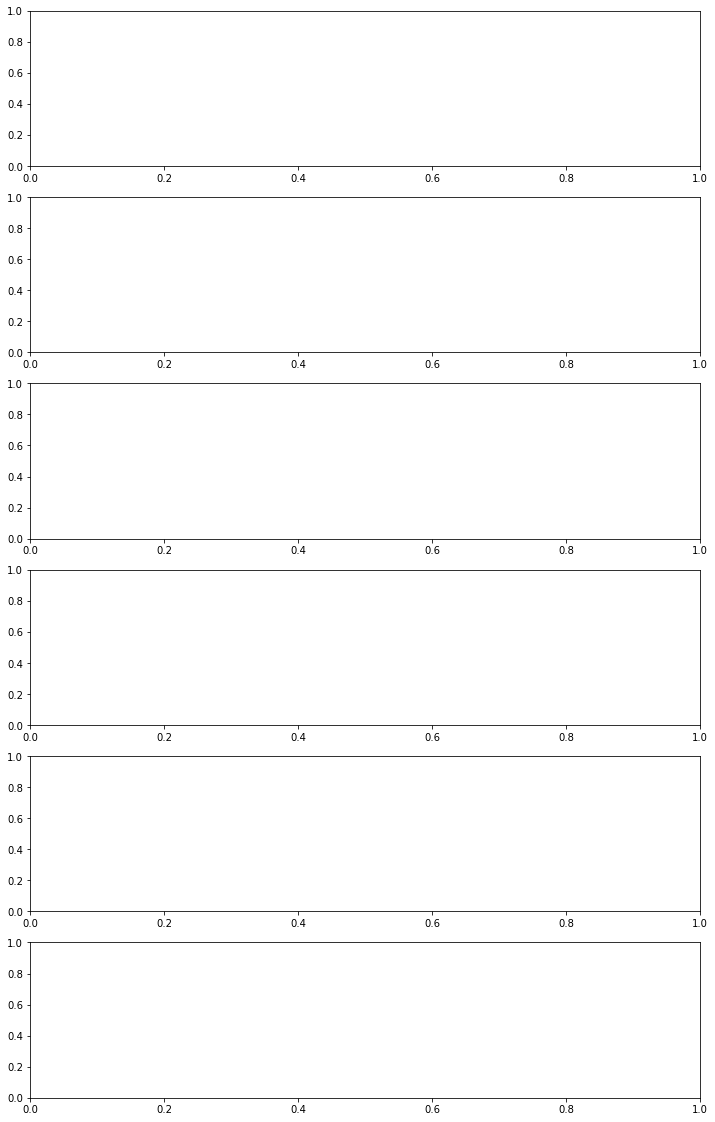

In [35]:
figure, axis = plt.subplots(6, figsize=(12, 20))
smacd.drawdown(bt_data, axis[0], "Strategy_Returns" )
print('\n')
smacd.drawdown(bt_data, axis[1], "Stock_Returns_AAPL")
smacd.drawdown(bt_data, axis[2], "Stock_Returns_META")
smacd.drawdown(bt_data, axis[3], "Stock_Returns_AMZN")
smacd.drawdown(bt_data, axis[4], "Stock_Returns_GOOG")
smacd.drawdown(bt_data, axis[5], "Stock_Returns_NFLX")

# Single Stock Demo

In [28]:
smacd_single = SMACD(["AAPL"],start,end,primary_trend_window,buy_on,verbose,lookback,metrics_calc_start_date)


Distribution of Positions,
  1.0    869
 0.0    266
-1.0     75
Name: Position, dtype: int64

Distribution of exits in percentages
 Close Long at TP     0.76
Close Long at SL     0.12
Close Short at TP    0.12
Name: Close_Entry, dtype: float64

Number of Entries and Exits are 50 and No trade are 266 

                      Normal       Log
Stock_Returns_AAPL  2.825553  1.038704
Benchmark_Returns   1.577461  0.455816
Strategy_Returns    3.096702  1.130338


,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio
Stock_Returns_AAPL,0.297515,0.239324,0.180759,1.243147,0.697749,0.426393,1.645924,0.193769,0.754285
Benchmark_Returns,0.121082,0.119442,0.099332,1.013730,0.277851,0.435780,1.218961,NaN,NaN
Strategy_Returns,0.327673,0.199447,0.156849,1.642912,0.308405,1.062476,2.089104,0.179767,0.940850


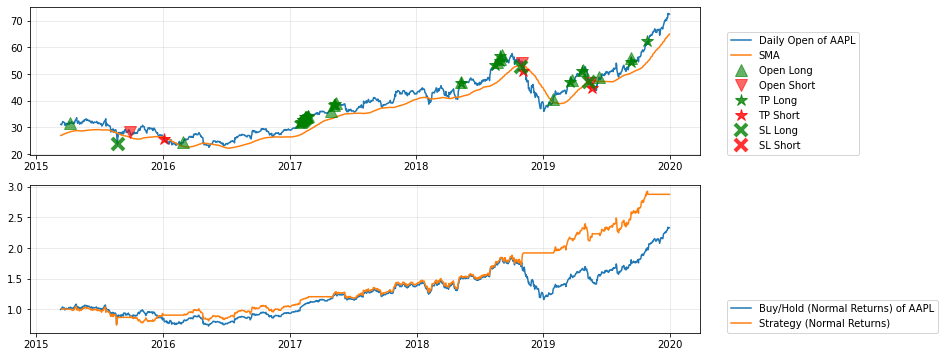

In [30]:
bt_data_single, returns_df_single,metrics_df_single= smacd_single.riding_the_trend_with_macd()
print(returns_df_single)
metrics_df_single

# CRYPTO Demo

In [32]:
start = "2018-01-01"
end = "2022-12-31"

# Long Parameters
long_sl_ATR_multiple = 1.5 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 3 # Used to determine how close to SMA can be bought
long_rsi_limit = 80

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 0.7   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5  # Used to determine how close to SMA can be bought
short_rsi_limit = 20

CRYPTO_list = ["BTC-USD","ETH-USD","XRP-USD","LTC-USD"]

In [33]:
smacd_crypto = SMACD(CRYPTO_list,start,end,primary_trend_window,buy_on,verbose,lookback,metrics_calc_start_date)


Distribution of Positions,
  1.0    836
 0.0    711
-1.0    138
Name: Position, dtype: int64

Distribution of exits in percentages
 Close Long at TP     0.336842
Close Long at SL     0.326316
Close Short at TP    0.210526
Close Short at SL    0.126316
Name: Close_Entry, dtype: float64

Number of Entries and Exits are 191 and No trade are 711 

                          Normal       Log
Stock_Returns_BTC-USD   1.747327  0.558087
Stock_Returns_ETH-USD   1.375857  0.319076
Stock_Returns_XRP-USD   0.373730 -0.984222
Stock_Returns_LTC-USD   0.231407 -1.463575
Benchmark_Returns       1.339110  0.292005
Strategy_Returns       50.944288  3.930733


,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio
Stock_Returns_BTC-USD,0.087101,0.600406,0.447505,0.145070,4.406484,0.019766,0.194636,0.634706,-0.162042
Stock_Returns_ETH-USD,0.048906,0.787384,0.575946,0.062112,3.921174,0.012472,0.084914,0.829584,-0.382542
Stock_Returns_XRP-USD,-0.136950,0.934139,0.610089,-0.146606,1.269317,-0.107893,-0.224475,0.937099,-0.661105
Stock_Returns_LTC-USD,-0.196690,0.820380,0.580868,-0.239755,1.494758,-0.131587,-0.338614,0.851767,-1.046754
Benchmark_Returns,0.065433,0.177553,0.145366,0.368526,0.422630,0.154823,0.450123,NaN,NaN
Strategy_Returns,0.801391,0.540795,0.427506,1.481875,25.911438,0.030928,1.874569,0.554826,0.300123


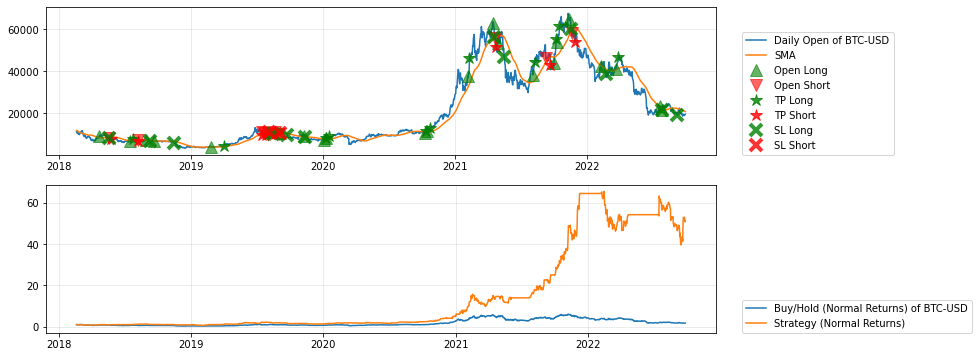

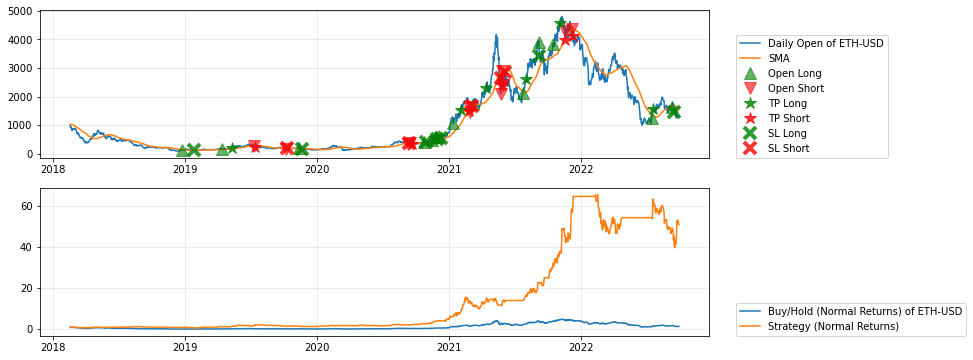

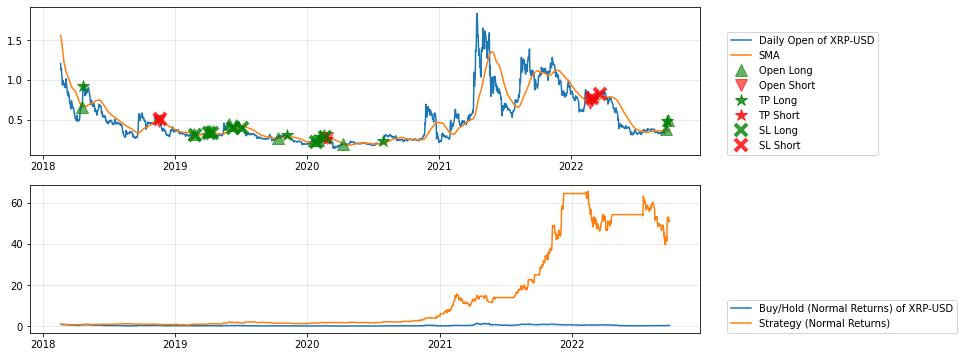

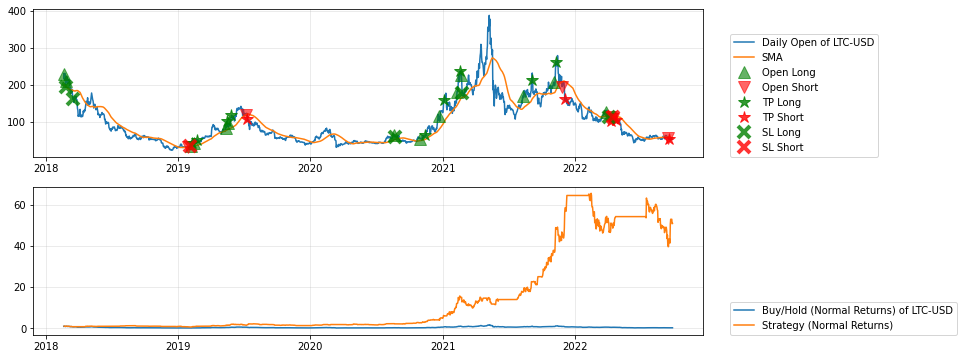

In [34]:
bt_data_crypto, returns_df_crypto,metrics_df_crypto= smacd_crypto.riding_the_trend_with_macd()
print(returns_df_crypto)
metrics_df_crypto

In [144]:
# def returns_plot_log(bt_data,plt,stock_symbol):
#     """
#     Function to plot the log returns of stock and strategy 
#     """
    
#     plt.plot(bt_data['Stock_Returns'+"_" + stock_symbol].cumsum(), label=f'Buy/Hold (Log Returns) of {stock_symbol}')
#     plt.plot(bt_data['Strategy_Returns'].cumsum(), label=f'Strategy (Log Returns)')
#     plt.legend(loc=(1.04, 0))
#     plt.grid(True, alpha=.3)

In [145]:
# def returns_plot_normal(bt_data,plt,stock_symbol):
#     """
#     Function to plot the normal returns of stock and strategy 
#     """
    
#     plt.plot(bt_data['Stock_Returns'+"_" + stock_symbol].cumsum().apply(np.exp), label=f'Buy/Hold (Normal Returns) of {stock_symbol}')
#     plt.plot(bt_data['Strategy_Returns'].cumsum().apply(np.exp), label=f'Strategy (Normal Returns)')
#     plt.legend(loc=(1.04, 0))
#     plt.grid(True, alpha=.3)

In [54]:
# def drawdown(bt_data,plt, col,plt_bool= True):
#     """
#     Function to plot the drawdown of column of returns 
#     """
#     bt_data["Gross_Cum_Returns"] = bt_data[col].cumsum().apply(np.exp) 
#     bt_data["Cum_Max"] = bt_data["Gross_Cum_Returns"].cummax()

#     if plt_bool:
#         plt.plot(bt_data["Gross_Cum_Returns"],label=f'Gross Cum Returns of {col}')
#         plt.plot(bt_data["Cum_Max"],label=f'Cum Max of {col}')
#         plt.legend(loc=(1.04, 0))
    
#     drawdown = bt_data["Cum_Max"] - bt_data["Gross_Cum_Returns"] # it gives the difference between orange and blue

#     bt_data["drawdown"] = drawdown

#     # The maximum difference is refered as "Drawdown"
#     if plt_bool: print(f"Max Drawdown for {col} is {bt_data.drawdown.max()}")
#     ## Try to keep to less than 15%

#     zero_periods = drawdown[drawdown == 0]
    
#     # Taking the difference from the previous period
#     delta_values = zero_periods.index[1:] - zero_periods.index[:-1]

#     if plt_bool: print(f'Max days for drawdown for {col} is {delta_values.max()}')
    
#     return bt_data.drawdown.max()


In [55]:
# def get_signals(stock_symbol, start, end,primary_trend_window = 200,buy_on="Close"):
#     """
#     Vectorised Function to get the signals for each day 
#     """
    
#     stock_data = pdr.get_data_yahoo(stock_symbol, start, end)
#     SMA = SMAIndicator(close = stock_data['Adj Close'], window = primary_trend_window)
#     ATR = AverageTrueRange(high = stock_data['High'],
#                        low = stock_data['Low'],
#                        close = stock_data['Adj Close'])
#     RSI = RSIIndicator(close =  stock_data['Adj Close'])
    
#     MACD_ = MACD(close = stock_data['Adj Close'])  

#     stock_data['SMA'] = SMA.sma_indicator()
#     stock_data['ATR'] = ATR.average_true_range()
#     stock_data['MACD Fast'] = MACD_.macd()
#     stock_data['MACD Slow'] = MACD_.macd_signal()
#     stock_data['RSI'] = RSI.rsi()

#     stock_data['Stop Loss'] = stock_data[buy_on] - long_sl_ATR_multiple*stock_data['ATR'] # 2
#     stock_data['Take Profit'] = stock_data[buy_on] +risk_reward_long*(stock_data[buy_on] - stock_data['Stop Loss']) # 1
    
#     stock_data['Stop Loss Short'] = stock_data[buy_on] + short_sl_ATR_multiple*stock_data['ATR'] # 1
#     stock_data['Take Profit Short'] = stock_data[buy_on] -risk_reward_short*(stock_data['Stop Loss Short'] - stock_data[buy_on]) # 0.5

#     bt_data = stock_data.copy()
#     bt_data.dropna(inplace = True)

#     # # Signal Logic
#     bt_data['signal_1'] = np.where( 
#                         (bt_data['Adj Close'] > (bt_data['SMA'] - close_n_sma_distance_short_multiple*bt_data['ATR']) ) & (bt_data['Adj Close'] < bt_data['SMA']),
#                         -1.0,   0) # When it is between the close and abit below it, we short, 0,5
    
#     bt_data['signal_1'] = np.where( 
#                         (bt_data['Adj Close'] < (bt_data['SMA'] + close_n_sma_distance_long_multiple*bt_data['ATR']) ) & (bt_data['Adj Close'] > bt_data['SMA']) ,
#                         1.0,  bt_data['signal_1']) # When it is between the close and abit above it, we long, 2
    
#     bt_data['signal_2'] = np.where(bt_data['MACD Fast'] >  bt_data['MACD Slow'],1.0,-1.0)
#     bt_data['Signal'] = ( bt_data['signal_1']+ bt_data['signal_2'] )/2.0
#     bt_data['Signal Clean'] = bt_data['Signal'].map(lambda x : 0 if x not in [-1.0,1.0] else x)
#     bt_data['Strength of Signal'] = ((abs(bt_data['Adj Close'] - bt_data['SMA'])/bt_data['Adj Close'] + abs(bt_data['MACD Fast'] -  bt_data['MACD Slow']))) * bt_data['Signal Clean']
#     bt_data['Stock_Returns'] = np.log(bt_data[buy_on]/bt_data[buy_on].shift(1)) 
#     bt_data['Stock_Returns'] = bt_data['Stock_Returns'].shift(-1) # Changed to tmr/today instead of today/yesterday
#     return bt_data

In [56]:
# def get_signal_for_mutiple_stocks(MAANG_list,start, end,primary_trend_window ,buy_on):
#     """
#     Function that combines data and signals for multiple stocks 
#     """
    
#     MAANG_list_abbr_list = []
    
#     # Intialise df with first stock in list 
#     signals_df = get_signals(MAANG_list[0], start, end,primary_trend_window,buy_on).add_suffix('_'+MAANG_list[0]) 
#     MAANG_list_abbr_list.append("Strength of Signal_" +MAANG_list[0])
#     for stock in MAANG_list[1:]:
#         stock_df = get_signals(stock, start, end,primary_trend_window = primary_trend_window,buy_on = buy_on)
#         signals_df= signals_df.merge(stock_df.add_suffix('_'+stock), how='right', left_index=True, right_index=True )
#         MAANG_list_abbr_list.append("Strength of Signal_" +stock)

#     signals_df['Chosen'] = signals_df[MAANG_list_abbr_list].abs().idxmax(axis=1)
#     signals_df['Chosen'] = np.where (signals_df[MAANG_list_abbr_list].abs().max(axis = 1) == 0.0, 0, signals_df['Chosen'])
#     temp_data = signals_df[MAANG_list_abbr_list].copy()

#     # If there are many signals in one day, replace them with the stock with the strongest signal
#     for i in range(len(temp_data)):
#         if (temp_data[i:i+1].max(axis = 1)[0] != 0.0):
#             stock_chosen = temp_data[i:i+1].abs().idxmax(axis=1)[0].split("_")[-1]
#             signals_df.loc[signals_df.index[i],MAANG_list_abbr_list] = [0.0] * len(MAANG_list)
#             signals_df.loc[signals_df.index[i],"Strength of Signal_"+stock_chosen] = signals_df.loc[signals_df.index[i],"Signal Clean_"+stock_chosen]

#     return signals_df, temp_data

In [57]:
# def get_positions(bt_data,buy_on, verbose = True ):
#     """
#     Function to set the entry points for the day.
#     Once, entered position will stay in that stock untill it hits TP or SL
#     After closing the position, based on the next signal a new position is opened.
#     """
    
#     latest_action,chosen_stock_for_entry = 0,""
#     curr_stop, curr_TP,buy_price,short_price = 0,0,0,0
#     bt_data[ "Open_Entry"] = 0.0
#     bt_data[ "Close_Entry"] = ""
#     bt_data[ "Stock_Returns_"] = 0.0
#     bt_data[ buy_on+"_"] = 0.0
#     buy_rsi = []
#     sell_rsi = []

#     # Loop through each day
#     for i in range(len(bt_data)):
#         curr_date = bt_data.index[i]
        
#         # If we have no prev position and a new signal is asking to take a position
#         if (bt_data['Chosen'].iloc[i] != 0.0) & (latest_action == 0):

#             chosen_stock_for_entry = bt_data['Chosen'].iloc[i].split('_')[-1]
            
#             # Enter Long on chosen stock
#             if (bt_data["Signal Clean_"+chosen_stock_for_entry].iloc[i]  == 1.0):
#                 curr_stop, curr_TP = bt_data.iloc[i]["Stop Loss_"+chosen_stock_for_entry],bt_data.iloc[i]["Take Profit_"+chosen_stock_for_entry]
#                 latest_action = 1.0
#                 bt_data.loc[curr_date, "Open_Entry"] = "Open Long"
#                 buy_price = bt_data.iloc[i+1][buy_on+"_" + chosen_stock_for_entry]
#                 buy_rsi.append(bt_data.iloc[i+1]["RSI_" + chosen_stock_for_entry])
#                 if verbose: print(f"Signal to Open Long on {chosen_stock_for_entry} on {curr_date} at {buy_price}")
            
#             # Enter Short on chosen stock
#             elif (bt_data["Signal Clean_"+chosen_stock_for_entry].iloc[i]  == -1.0):
#                 curr_stop, curr_TP = bt_data.iloc[i]["Stop Loss Short_"+chosen_stock_for_entry],bt_data.iloc[i]["Take Profit Short_"+chosen_stock_for_entry]
#                 latest_action = -1.0  
#                 bt_data.loc[curr_date, "Open_Entry"] = "Open Short"
#                 short_price = bt_data.iloc[i+1][buy_on+"_" + chosen_stock_for_entry]
#                 sell_rsi.append(bt_data.iloc[i+1]["RSI_" + chosen_stock_for_entry])
#                 if verbose: print(f"Signal to Open Short on {chosen_stock_for_entry} on {curr_date} at {short_price}")
                
#         # if we are already in a long    
#         elif (latest_action == 1.0):
#             # Close Long if it hits TP
#             if (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  >= curr_TP ) | (bt_data.iloc[i]["RSI_" + chosen_stock_for_entry]>long_rsi_limit): 
#                 bt_data.loc[curr_date, "Close_Entry"] = "Close Long at TP"
#                 if verbose: print(f"Signal to Take Profit on Long with {chosen_stock_for_entry} on {curr_date} at {curr_TP} with a profit of {(curr_TP-buy_price)/buy_price}")
#                 latest_action,curr_stop, curr_TP = 0,0, 0
                

#             # Close Long if it hits SL
#             elif (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  <= curr_stop ): 
#                 bt_data.loc[curr_date, "Close_Entry"] = "Close Long at SL"
#                 if verbose:print(f"Signal to Stop Loss on Long on {chosen_stock_for_entry} on {curr_date} at {curr_stop} with a loss of {(curr_stop-buy_price)/buy_price}")
#                 latest_action,curr_stop, curr_TP = 0,0, 0
                
#         # if we are already in a short
#         elif (latest_action == -1.0):
            
#             # Close Short if it hits SL
#             if (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  >= curr_stop) : 
#                 bt_data.loc[curr_date, "Close_Entry"] = "Close Short at SL"
#                 if verbose: print(f"Signal to Stop Loss on Short with {chosen_stock_for_entry} on {curr_date} at {curr_stop} with a loss of {-(curr_stop-short_price)/short_price}")
#                 latest_action,curr_stop, curr_TP = 0,0, 0
                

#             # Close Short if it hits TP
#             elif (bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  <= curr_TP) | (bt_data.iloc[i]["RSI_" + chosen_stock_for_entry]<short_rsi_limit): 
#                 bt_data.loc[curr_date, "Close_Entry"] = "Close Short at TP"
#                 if verbose: print(f"Signal to Take Profit on Short on {chosen_stock_for_entry} on {curr_date} at {curr_TP} with a profit of {-(curr_TP-short_price)/short_price}")
#                 latest_action,curr_stop, curr_TP = 0,0, 0
            
#         bt_data.loc[curr_date, "Position"] = latest_action
#         bt_data.loc[curr_date, "Invested Stock Returns"] = bt_data.loc[curr_date, "Stock_Returns_" + chosen_stock_for_entry]
#         bt_data.loc[curr_date, "Invested Stock Price"] = bt_data.loc[curr_date, buy_on+"_" + chosen_stock_for_entry]
#         bt_data.loc[curr_date, "Invested in"] = chosen_stock_for_entry
#     return bt_data, buy_rsi, sell_rsi

In [138]:
# def riding_the_trend_with_macd(data, MAANG_list, start, end,lookback = 252, buy_on = "Close",verbose = True,metrics_calc_start_date = "2015-01-01"):
#     benchmark_data = pdr.get_data_yahoo(benchmark_stock_symbol, start, end)
#     # Getting the signals for all the stocks for each day
#     bt_data = data.copy()
    
#     # Getting position for each day based on the strongest signal
#     bt_data, buy_rsi, sell_rsi  = get_positions(bt_data,buy_on,verbose)
    
#     # Printing the distribution of positions
#     print("\nDistribution of Positions,\n",bt_data.Position.value_counts())
#     assert bt_data.Position.isin([-1.0,0,1.0]).all(), "Position values are out of range:\n"  + bt_data.Position.value_counts().to_string()

#     # Printing the number of entires and exits 
#     number_trades = bt_data[bt_data.Open_Entry != 0.0].Open_Entry.count() + bt_data[bt_data.Close_Entry != ""].Close_Entry.count()
#     no_trades = bt_data[bt_data.Position == 0.0].Position.count() 
#     print("\nDistribution of exits in percentages\n",bt_data[bt_data.Close_Entry != ""].Close_Entry.value_counts(normalize=True))
#     print(f'\nNumber of Entries and Exits are {number_trades} and No trade are {no_trades} \n' )

#     # Assuming, we get a signal on open and we are able to buy on the same day open as well
#     bt_data['Benchmark_Returns'] = np.log(benchmark_data[buy_on]/benchmark_data[buy_on].shift(1))
#     bt_data['Benchmark_Returns'] = bt_data['Benchmark_Returns'].shift(-1)
#     bt_data['Strategy_Returns'] = bt_data['Position'].shift(1) * bt_data['Invested Stock Returns'] # since you enter next day
#     bt_data["Invested in"] = bt_data.apply(lambda row: row["Invested in"] if (row["Strategy_Returns"]!=0.0) else "", axis = 1)
    
#     # Plotting entry points and returns 
#     for stock in MAANG_list:
#         figure, axis = plt.subplots(2,figsize=(12, 6))
#         entry_price_plot(bt_data.iloc[-lookback:], axis[0],stock,buy_on )
#         returns_plot_normal(bt_data, axis[1],stock)
    
#     # Metrics
#     returns_df = pd.DataFrame()
#     MAANG_list_abbr_list = []
#     for stock in MAANG_list:
#         MAANG_list_abbr_list.append("Stock_Returns_" +stock)
#     MAANG_list_abbr_list.extend(["Benchmark_Returns","Strategy_Returns"])
    
#     returns_df["Normal"] = bt_data[metrics_calc_start_date:][MAANG_list_abbr_list].sum().apply(np.exp)
#     returns_df["Log"] = bt_data[metrics_calc_start_date:][MAANG_list_abbr_list].sum()
    
#     metrics_df = pd.DataFrame()
#     metrics_df["Annual Mean Returns"] = np.exp(bt_data[metrics_calc_start_date:][MAANG_list_abbr_list].mean() * 252) -1

#     # Annual Standard deviation
#     metrics_df["Annual Regular std"] = (np.exp(bt_data[metrics_calc_start_date:][MAANG_list_abbr_list])-1).std() * (252 **0.5)  # Note that these are the log returns
    
#     # Annual Standard deviation of Neg Returns
#     neg_ret_std = []
#     tracking_err = []
#     information_ratio = []
#     for stock in MAANG_list_abbr_list:
#         neg_ret_std.append((np.exp(bt_data[bt_data[stock] <0][metrics_calc_start_date:][stock])-1).std() * (252 **0.5) )
#         if stock != "Benchmark_Returns":
#             rf_rm_diff = bt_data[metrics_calc_start_date:][stock] - bt_data[metrics_calc_start_date:]["Benchmark_Returns"]
#             avg_of_diff_daily = rf_rm_diff.mean()
#             sd_of_diff_daily = rf_rm_diff.std()
#             IRR_daily = avg_of_diff_daily/sd_of_diff_daily
#             tracking_err.append(sd_of_diff_daily*(252**0.5))
#             information_ratio.append(IRR_daily *(252**0.5) )
#         else:
#             tracking_err.append(np.nan)
#             information_ratio.append(np.nan )
#     metrics_df["Annual Negative Regular std"] = neg_ret_std
    
#     # Sharpe Ratio
#     metrics_df["Annual Sharpe Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Annual Regular std'] 
    
#     # Max Drawdown
#     metrics_df["Max Drawdown"] =list(map(lambda x: drawdown(bt_data, 0, x, False),MAANG_list_abbr_list))
    
#     # Calamar Ratio
#     metrics_df["Annual Calamar Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Max Drawdown'] 
    
#     # Shortino Ratio
#     metrics_df["Annual Shortino Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Annual Negative Regular std'] 

#     # Tracking Error
#     metrics_df["Annual Tracking Error"] = tracking_err
    
#     # Information Ratio
#     metrics_df["Annual Information Ratio"] =information_ratio
    
#     return bt_data, returns_df,metrics_df, buy_rsi, sell_rsi